#### Manual testing...

This notebook serves as an integration test to confirm that the model is behaving as we expect.

In [23]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import time

%matplotlib inline

In [2]:
MODEL_DIR = os.path.realpath(os.path.dirname('..\superscript_model'))
sys.path.append(os.path.normpath(MODEL_DIR))

In [3]:
from superscript_model import model
from superscript_model.utilities import Random

In [4]:
abm = model.SuperScriptModel(1000)

In [24]:
steps = range(1000)
active_projects = []
team_size = []

for step in steps:
    
    start_time = time.time()
    abm.step()
    elapsed_time = time.time() - start_time  
    print("Step %d took %.2f seconds" % (step, elapsed_time))
    
    size = 0
    active_projects.append(abm.inventory.active_count)
    
    for project in abm.inventory.projects.values():
        size += len(project.team.members)
    team_size.append(size/len(abm.inventory.projects.values()))

Step 0 took 0.64 seconds
Step 1 took 0.75 seconds
Step 2 took 0.73 seconds
Step 3 took 0.70 seconds
Step 4 took 0.64 seconds
Step 5 took 0.66 seconds
Step 6 took 0.66 seconds
Step 7 took 0.69 seconds
Step 8 took 0.62 seconds
Step 9 took 0.60 seconds
Step 10 took 0.62 seconds
Step 11 took 0.62 seconds
Step 12 took 0.63 seconds
Step 13 took 0.62 seconds
Step 14 took 0.64 seconds
Step 15 took 0.62 seconds
Step 16 took 0.60 seconds
Step 17 took 0.61 seconds
Step 18 took 0.63 seconds
Step 19 took 0.60 seconds
Step 20 took 0.70 seconds
Step 21 took 0.63 seconds
Step 22 took 0.65 seconds
Step 23 took 0.77 seconds
Step 24 took 0.66 seconds
Step 25 took 0.64 seconds
Step 26 took 0.61 seconds
Step 27 took 0.63 seconds
Step 28 took 0.63 seconds
Step 29 took 0.65 seconds
Step 30 took 0.82 seconds
Step 31 took 0.70 seconds
Step 32 took 0.69 seconds
Step 33 took 0.68 seconds
Step 34 took 0.75 seconds
Step 35 took 0.61 seconds
Step 36 took 0.64 seconds
Step 37 took 0.68 seconds
Step 38 took 0.65 seco

Step 308 took 0.64 seconds
Step 309 took 0.64 seconds
Step 310 took 0.66 seconds
Step 311 took 0.65 seconds
Step 312 took 0.73 seconds
Step 313 took 0.70 seconds
Step 314 took 0.65 seconds
Step 315 took 0.66 seconds
Step 316 took 0.60 seconds
Step 317 took 0.60 seconds
Step 318 took 0.66 seconds
Step 319 took 0.64 seconds
Step 320 took 0.63 seconds
Step 321 took 0.63 seconds
Step 322 took 0.61 seconds
Step 323 took 0.72 seconds
Step 324 took 0.61 seconds
Step 325 took 0.63 seconds
Step 326 took 0.64 seconds
Step 327 took 0.65 seconds
Step 328 took 0.61 seconds
Step 329 took 0.61 seconds
Step 330 took 0.62 seconds
Step 331 took 0.63 seconds
Step 332 took 0.68 seconds
Step 333 took 0.62 seconds
Step 334 took 0.63 seconds
Step 335 took 0.61 seconds
Step 336 took 0.62 seconds
Step 337 took 0.64 seconds
Step 338 took 0.62 seconds
Step 339 took 0.64 seconds
Step 340 took 0.64 seconds
Step 341 took 0.72 seconds
Step 342 took 0.70 seconds
Step 343 took 0.66 seconds
Step 344 took 0.62 seconds
S

Step 612 took 0.79 seconds
Step 613 took 0.75 seconds
Step 614 took 0.78 seconds
Step 615 took 0.75 seconds
Step 616 took 0.65 seconds
Step 617 took 0.65 seconds
Step 618 took 0.68 seconds
Step 619 took 0.66 seconds
Step 620 took 0.74 seconds
Step 621 took 0.76 seconds
Step 622 took 0.76 seconds
Step 623 took 0.69 seconds
Step 624 took 0.67 seconds
Step 625 took 0.82 seconds
Step 626 took 0.71 seconds
Step 627 took 0.97 seconds
Step 628 took 0.72 seconds
Step 629 took 0.75 seconds
Step 630 took 0.69 seconds
Step 631 took 0.73 seconds
Step 632 took 0.71 seconds
Step 633 took 0.68 seconds
Step 634 took 0.67 seconds
Step 635 took 0.65 seconds
Step 636 took 0.70 seconds
Step 637 took 0.73 seconds
Step 638 took 0.77 seconds
Step 639 took 0.79 seconds
Step 640 took 0.80 seconds
Step 641 took 0.83 seconds
Step 642 took 0.69 seconds
Step 643 took 0.84 seconds
Step 644 took 0.85 seconds
Step 645 took 0.76 seconds
Step 646 took 0.85 seconds
Step 647 took 1.04 seconds
Step 648 took 0.66 seconds
S

Step 916 took 0.72 seconds
Step 917 took 0.72 seconds
Step 918 took 0.64 seconds
Step 919 took 0.69 seconds
Step 920 took 0.72 seconds
Step 921 took 0.74 seconds
Step 922 took 0.61 seconds
Step 923 took 0.63 seconds
Step 924 took 0.76 seconds
Step 925 took 0.84 seconds
Step 926 took 0.78 seconds
Step 927 took 0.78 seconds
Step 928 took 0.80 seconds
Step 929 took 0.65 seconds
Step 930 took 0.76 seconds
Step 931 took 0.86 seconds
Step 932 took 0.68 seconds
Step 933 took 0.66 seconds
Step 934 took 0.64 seconds
Step 935 took 0.77 seconds
Step 936 took 0.80 seconds
Step 937 took 0.74 seconds
Step 938 took 0.81 seconds
Step 939 took 0.85 seconds
Step 940 took 0.79 seconds
Step 941 took 0.73 seconds
Step 942 took 0.72 seconds
Step 943 took 0.71 seconds
Step 944 took 0.70 seconds
Step 945 took 0.71 seconds
Step 946 took 0.75 seconds
Step 947 took 0.70 seconds
Step 948 took 0.75 seconds
Step 949 took 0.83 seconds
Step 950 took 0.80 seconds
Step 951 took 0.71 seconds
Step 952 took 0.75 seconds
S

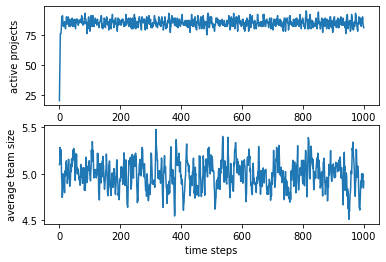

In [6]:
plt.subplot(2,1,1)
plt.plot(steps, active_projects)
plt.ylabel('active projects')

plt.subplot(2,1,2)
plt.plot(steps, team_size)
plt.xlabel('time steps')
plt.ylabel('average team size');

In [7]:
print(np.mean(active_projects[200:]))
print(np.mean(team_size[200:]))

85.06875
4.989549039517669


#### We now select a random worker from the model and inspect the worker:

This produces a json formatted text summary of the worker. Note that this representation will be updated when we add in the worker's history and project activities.

In [8]:
random_worker = Random.choice(abm.schedule.agents)

print(random_worker.skills.to_string())

{
    "Worker OVR": 77.3,
    "Hard skills": [
        5.0,
        1.3,
        4.9,
        4.3,
        0.0
    ],
    "Soft skills": [
        4.2,
        1.4,
        1.5,
        2.0,
        2.6
    ],
    "Hard skill probability": 0.8,
    "OVR multiplier": 20
}


#### We now do the same for a randomly selected project..

In [9]:
random_project = Random.choice(list(abm.inventory.projects.values()))

In [10]:
print(random_project.requirements.to_string())

{
    "risk": 10,
    "creativity": 5,
    "flexible_budget": false,
    "max_budget_increase": 0.25,
    "p_hard_skill_required": 0.8,
    "min_skill_required": 2,
    "per_skill_cap": 7,
    "total_skill_units": 5,
    "hard_skills": {
        "A": {
            "level": 1,
            "units": 2
        },
        "B": {
            "level": null,
            "units": 0
        },
        "C": {
            "level": 1,
            "units": 1
        },
        "D": {
            "level": 3,
            "units": 2
        },
        "E": {
            "level": null,
            "units": 0
        }
    }
}


#### For this project we can also inspect the Team:

### Note: here the team of 5 is doing its best to meet the high skill unit requirements...Check with Michael. 

In [11]:
print(random_project.team.to_string())

{
    "project": 19941,
    "members": [
        986,
        8,
        74,
        556
    ],
    "lead": 986,
    "success_probability": 0.5,
    "team_ovr": 52.5,
    "skill_balance": 0.0,
    "creativity_match": 3.5,
    "skill_contributions": {
        "A": [
            74,
            556
        ],
        "C": [
            8
        ],
        "D": [
            74,
            986
        ]
    }
}


#### Note that allocating the total skill units across the skills in a robust way was a non-trivial problem! Solved as follows...

*(Move this to another notebook).*

Select 5 numbers in (1,10) that sum to X, where X <=50
Always a = max(a,1) and b = min(b,10)
-	Select n1 randint(a,b) where a = X – (4\*10) and b = X – (4\*1)
-	Select n2 randint(a,b) where a = X – n1 – (3\*10) and b = X – n1 – (3\*1)
-	Select n3 randint(a,b) where a = X – n1 – n2 – (2\*10) and b = X – n1 – n2 – (2\*1)
-	…
-	Select n5 randint(a,b) where a = X – n1 – n2 – n3 – n4 and b = X – n1 – n2 – n3 – n4


In [12]:
def generate_skills(total):

    min_units = 1
    max_units = 10

    remaining = total
    length = 5

    assert total <= length*max_units
    assert total >= length*min_units

    skills = []

    for i in range(length):

        a = remaining - (length - (i+1))*max_units
        a = max(a, min_units)

        b = remaining - (length - (i+1))*min_units
        b = min(b, max_units)

        n = Random.randint(a,b)
        skills.append(n)
        remaining -= n
        
    assert sum(skills) == total
    return skills

In [13]:
for t in np.arange(5,50):
    print(generate_skills(t), "; sum = ", t)

[1, 1, 1, 1, 1] ; sum =  5
[2, 1, 1, 1, 1] ; sum =  6
[1, 3, 1, 1, 1] ; sum =  7
[4, 1, 1, 1, 1] ; sum =  8
[2, 2, 3, 1, 1] ; sum =  9
[5, 1, 1, 1, 2] ; sum =  10
[7, 1, 1, 1, 1] ; sum =  11
[1, 4, 3, 1, 3] ; sum =  12
[2, 3, 2, 3, 3] ; sum =  13
[10, 1, 1, 1, 1] ; sum =  14
[2, 1, 5, 1, 6] ; sum =  15
[1, 9, 1, 3, 2] ; sum =  16
[2, 3, 9, 1, 2] ; sum =  17
[6, 9, 1, 1, 1] ; sum =  18
[5, 5, 3, 1, 5] ; sum =  19
[6, 2, 7, 4, 1] ; sum =  20
[3, 7, 2, 7, 2] ; sum =  21
[2, 6, 2, 6, 6] ; sum =  22
[10, 7, 3, 1, 2] ; sum =  23
[1, 7, 1, 8, 7] ; sum =  24
[8, 8, 7, 1, 1] ; sum =  25
[5, 3, 3, 7, 8] ; sum =  26
[7, 2, 2, 10, 6] ; sum =  27
[3, 3, 9, 4, 9] ; sum =  28
[1, 3, 5, 10, 10] ; sum =  29
[7, 1, 2, 10, 10] ; sum =  30
[1, 6, 6, 8, 10] ; sum =  31
[4, 7, 6, 9, 6] ; sum =  32
[2, 4, 10, 7, 10] ; sum =  33
[4, 4, 9, 8, 9] ; sum =  34
[6, 3, 9, 9, 8] ; sum =  35
[4, 7, 10, 7, 8] ; sum =  36
[3, 6, 10, 8, 10] ; sum =  37
[10, 5, 4, 10, 9] ; sum =  38
[2, 7, 10, 10, 10] ; sum =  39
[9, 2, 

In [14]:
from itertools import combinations

In [15]:
list(combinations([1], 2))

[]

In [16]:
test = {1:2}

In [17]:
Random.choices([1], 3)

[1, 1, 1]

In [18]:
test = np.int32(1)
t = {test: 1}

In [19]:
test = {1:2, 3:4}

In [20]:
max(0,3)

3

In [26]:
len(range(10))

10